In [1]:
import os

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.pyplot import yscale

# %matplotlib inline

# Coding the algorithm

In [2]:
class Gaussian2D:
  def __init__(self, width, amplitude, origin):
    self.width = width / np.sqrt(2)
    self.amplitude = amplitude
    self.origin = np.array(origin)

  def __call__(self, x, y):
    d = (x-self.origin[0]) ** 2 + (y - self.origin[1]) ** 2
    return self.amplitude * np.exp(-0.5 * d / self.width**2) / (2 * np.pi * self.width ** 2)
  
  def analytical_evol(self, x, y, Z, Nz, k):
      Z_arr = np.linspace(0, Z, Nz)[: , None, None]
      d = (x - self.origin[0]) ** 2 + (y - self.origin[1]) ** 2
      a = 1 / (2 * 1j * k * self.width ** 2)
      return np.abs(Z_arr * a * (2 + (d/self.width**2)) * self(x, y))

In [4]:
class PhaseScreen:
    def __init__(self, L, Z, Nz, Nx, k, C_n, L_0, kappa):
        self.dZ = Z / Nz
        self.Nx = Nx
        self.dkappa = 2 * np.pi / L
        Phi_n = 0.033 * C_n * (kappa ** 2 + L_0**(-2)) ** (-11/6)
        self.Phi_theta = 2 * np.pi * k ** 2  * self.dZ * Phi_n

    def randmatrix(self):
        A, B = np.random.normal(size=(self.Nx,self.Nx)), np.random.normal(size=(self.Nx,self.Nx))
        noise = (A + 1j*B) * self.dkappa ** (-1) * np.sqrt(self.Phi_theta)
        #noisefourier = 2 * np.pi * np.fft.ifft2(noise)/ self.dZ ** 2
        noisefourier = 2 * np.pi * np.fft.ifft2(noise)
        return noisefourier.real

In [5]:
class Spectral:
  def __init__(self, L, Z, Nz, Nx, k, C_n, L_0, N_int=2**5):
        self.L = L # Length of the spatial grids (m)
        self.Nz = Nz # Subdivision of the propagation axis / number of screens (1)
        self.Nx = Nx # Subdivision of the spatial and spectral grids (1)
        self.k = k # wavenumber (/m)
        self.N_int = N_int # Number of steps to save
        self.Z = Z # final observation height (m)
        self.dZ = self.Z / self.Nz 
        
        #spatial grid
        _range_spatial = np.linspace(-L/2, L/2, num = self.Nx, endpoint=False)
        self.x, self.y = np.meshgrid(_range_spatial, _range_spatial)

        #spectral grid
        spacing = L/self.Nx
        _range_spectral = 2 * np.pi * np.fft.fftfreq(self.Nx, d=spacing)
        self.kappax, self.kappay = np.meshgrid(_range_spectral, _range_spectral)
        # Pre-computing
        self.kappa = (self.kappax ** 2 + self.kappay ** 2) ** 0.5
        self.fourier_mult = np.exp(-1j * self.kappa ** 2 * self.dZ / (2 * self.k))

        # Array allocation
        self.evol = np.zeros([self.N_int + 1, self.Nx, self.Nx], dtype=complex)
        self.u = np.zeros([self.Nx, self.Nx], dtype=complex)
        
        # Phase screen

        # Optimizing the phase screen interval
        self.phase_screen = PhaseScreen(L, Z, Nz, Nx, k, C_n, L_0, self.kappa)
        # m = np.max(np.abs(self.phase_screen.randmatrix())) # find max(k_0 * n_1 * dZ)
        # if m <= 2 * np.pi / 10:
        #     # We can do less screens than Z intervals. 
        #     dz_bound = (2 * np.pi / 10) * self.dZ / m # find bound for new dZ_screens
        #     n_s = 2 ** np.ceil(np.log2(Z / dz_bound))
        #     print(f'We actually only need {n_s:.1g} screens with {Nz} z-steps')
        #     new_dZ = Z / n_s
        #     self.phase_screen = PhaseScreen(L, Z, n_s, Nx, k, C_n, L_0, self.kappa)
        #     m_new = np.max(np.abs(self.phase_screen.randmatrix()))
        #     print('10 * m / 2 pi', m / (2 * np.pi / 10))
        

  def initialize(self, u0):
      self.u = u0

  
  def step(self, phase=True):
      if phase:
          phase_mult = np.exp(1j * self.phase_screen.randmatrix())
          
          self.u = np.fft.ifft2(np.fft.fft2(self.u * phase_mult) * self.fourier_mult)
      else:
          self.u = np.fft.ifft2(np.fft.fft2(self.u) * self.fourier_mult)

  def advance(self, phase=True):
      for i in range(self.Nz+1):
          # Saving
          if i % (self.Nz // self.N_int) == 0:
              self.evol[self.N_int * i // self.Nz] = self.u
          # Making the step
          self.step(phase)
          # Run progress
          if i == self.Nz // 50  or i % (self.Nz // 10) == 0:
              print(100 * i // Nz, '%')
      # Saving the last value
      self.evol[-1] = self.u


In [6]:
# For arrays like evolution
def Diag2D(u, x, y):
    dxdy = (x[0, 1] - x[0, 0]) * (y[1, 0] - y[0, 0])
    u2 = u ** 2
    p = np.sum(u2)
    x_c, y_c = np.sum(x*u2) / p, np.sum(y*u2) / p
    d = (x-x_c) ** 2 + (y-y_c) ** 2
    return p * dxdy, x_c, y_c, (np.sum(d * u2) / p) ** 0.5

# For arrays like evolution
def Diag3D(evol, x, y):
    dxdy = (x[0, 1] - x[0, 0]) * (y[1, 0] - y[0, 0])
    u2 = evol ** 2
    p = np.sum(u2, axis=(1, 2))
    x_c, y_c = np.sum(x*u2, axis=(1,2)) / p, np.sum(y*u2, axis=(1,2)) / p
    d = (x-x_c[:, None, None]) ** 2 + (y-y_c[:, None, None]) ** 2
    return p * dxdy, x_c, y_c, (np.sum(d * u2, axis=(1, 2)) / p) ** 0.5


In [7]:
def analytical(x, y, width, x0, y0, U_0, Z, Nz,  k):
    #renormalisation
    D = -1 / (2 * 1j * k)
    Z_arr = np.linspace(0, Z, Nz)[:, None, None]
    sigma = (width**2 / 2) + 2 * D * Z_arr 
    norm_factor = U_0 / (2 * np.pi * sigma)
    exponent = -((x - x0)**2 + (y - y0)**2) / (2 * sigma)
    return np.abs(norm_factor * np.exp(exponent))

In [8]:
def analytical_new(x, y, width, x0, y0, U_0, Z, Nz,  k):
    #renormalisation
    D = -1 / (2 * 1j * k)
    Z_arr = np.linspace(0, Z, Nz)[:, None, None]
    sigma = width ** 2  + 4 * D * Z_arr 
    norm_factor = U_0 / (np.pi * sigma)
    exponent = -((x - x0)**2 + (y - y0)**2) / sigma
    return np.abs(norm_factor * np.exp(exponent))

# Running the simulation
In the first cell we set the parameters and initial conditions. We then initialise the algorithm
We also run diagnostics about how valid our assumptions are in these conditions. 

In the second cell we run the bulk of the algorithm - the longest and most computationally expensive part. 
We then save the results (the array of the amplitude evolution) into a file. 

In [19]:
# Simulation parameters
Nz = 10
Nx = 2 ** 10

L = 4# m

N_int = 10

# Physical parameters
Z = 1 # m
L_0 = 10 # m
#C_n = 5E-16 # units ? 
#C_n = 4E-14
C_n = 5E-7

wavelength = 4.2E-7 # m
#wavelength = 5.2E-7

w_0 = 0.5# m
A = 1 # 

k = 2 * np.pi / wavelength

phase = False

# Initialization

s = Spectral(L, Z, Nz, Nx, k, C_n, L_0, N_int)
g = Gaussian2D(w_0, A, (0, 0))

s.initialize(g(s.x, s.y)) # initialize to a 2D Gaussian

# Diagnostics
Z_r = 0.5 * k * w_0 ** 2 # Rayleigh length
Delta = L / Nx


F = w_0** 2 / (Z * wavelength)
print(f"Fresnel number (F) = {F:.2g}")

k_min, k_max = np.pi / Nx, np.pi
print(f"k_min = {k_min:.2g} <= {k:.2g} <= {k_max:.2g} = k_max | {k_min <= k <= k_max}")
print(f"Z interval = {Z / Nz :.2g} m vs {Z_r / 10:.2g} m = Z_r | {Z / Nz <= Z_r / 10}")
print(f"X interval = {L / Nx :.2g} m vs {w_0 / 10 :.2g} m = w_0 / 10 | {L / Nx <= w_0 / 10}")
print(f"Wavenumber = {k :.7g} m vs {np.pi * Nz / Z:.2g} m = k_Nyquist | {k <= np.pi * Nz / Z}")
print(f"Fresnel length  {np.sqrt(Z * wavelength):.2g} m  ~ {Z / Nz :.2g} m = dZ")


Fresnel number (F) = 6e+05
k_min = 0.0031 <= 1.5e+07 <= 3.1 = k_max | False
Z interval = 0.1 m vs 1.9e+05 m = Z_r | True
X interval = 0.0039 m vs 0.05 m = w_0 / 10 | True
Wavenumber = 1.495997e+07 m vs 31 m = k_Nyquist | False
Fresnel length  0.00065 m  ~ 0.1 m = dZ


In [20]:
# Propagation Diagnostics:
'''
1. There should be 10 baskets within the initial waist width
2. The final size of the beam should be 1/4 of L
3. Z_r should be big, at least compared to Z
'''

Z_r = 0.5 * k * w_0 ** 2
w_z = w_0 * np.sqrt(1+(Z/Z_r)**2) / np.sqrt(2)
print(f'initial size of the beam {w_0}')
print(f'final size of the beam {w_z}')
print(f'L/4 is {L/4}')
print(f'Z is {Z}')
print(f'Zr is {Z_r}')


if L / Nx >= w_0 / 10:
    print(f'!Spatial grid spacing is {(10 * L)/(Nx * w_0):.2g}x too big: dx = {L / Nx :.2g} m >= {w_0 / 10 :.2g} m = w_0/10')

if w_z >= L/4:
    print(f'!Spatial grid is too small. The final radius {w_z:.2g} m will not fit in the box of size L = {L:.2g} m')
    
if Z/Z_r >= 20:
    print(f'Warning: Z = {Z*1E-3:.2g} km is much bigger than Z_r = {Z_r * 1E-3:.2g} km, so the beam width will significantly increase. This may be computationally inefficient')



initial size of the beam 0.5
final size of the beam 0.3535533905933243
L/4 is 1.0
Z is 1
Zr is 1869995.6271367816


In [29]:
# Phase screen Diagnostics: 
'''   
delta_phi = k_0 * n(x, y) delta_z <= 2 * pi / 10
Must always be satisfied, with the max amplitude of n(x, y)
This is the same as our randmatrix() output, but take max over (x, y)
'''

m = np.max(np.abs(s.phase_screen.randmatrix()))
if m >= 2 * np.pi / 10:
    print('Interscreen distance too big')
else:
    print(f'We can maybe put less screens m = {m:.2g}')


We can maybe put less screens m = 0.0084


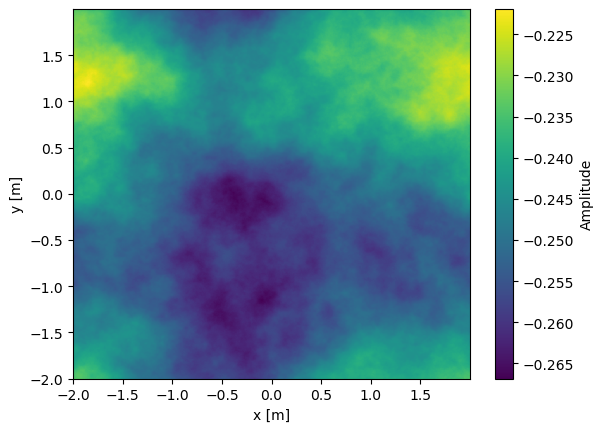

In [21]:
plt.pcolormesh(s.x, s.y, s.phase_screen.randmatrix())
plt.ylabel('y [m]')
plt.xlabel('x [m]')
#plt.bar('Amplitude')
plt.colorbar(label = 'Amplitude')

In [12]:
# Normalising coordinates

delta_k_norm = 2 * np.pi/Nx
Delta_norm = 1
interscreen_dist_norm = Z/(Nz * Delta)
r_f = np.sqrt(interscreen_dist_norm/k)

**Run the algorithm in this cell**

The results are saved in the file, make sure not to overwrite another result when doing so. 
The parameters are also saved into the file. 
Progress of the algorithm is indicated to estimate ETA, but not progress in saving the file!

In [22]:
import os
filename = 'saves/good7.npz'

assert(not os.path.exists(filename)) 

s.advance(phase)

np.savez_compressed(filename, 
         u_evol = np.abs(s.evol), 
         L = L, Z = Z, Nz = Nz, Nx = Nx, k = k, C_n = C_n, L_0 = L_0, w_0 = w_0, A = A, phase=phase)

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


# Visualising and studying the results

Loading the results. 

In [23]:
name = 'good7'
file = np.load(f"saves/{name}.npz")
print('loaded')
u_evol, L, Z, Nz, Nx, k, C_n, L_0, w_0, A = file['u_evol'], file['L'], file['Z'], file['Nz'], file['Nx'], file['k'], file['C_n'], file['L_0'], file['w_0'], file['A']
phase = file['phase']

_range_spatial = np.linspace(-L/2, L/2, num = Nx, endpoint=False)
Xgrid, Ygrid = np.meshgrid(_range_spatial, _range_spatial)

u_evol = np.abs(u_evol)
print('absoluted')

# print(u_evol)
Nb_evol = u_evol.shape[0]
g = Gaussian2D(w_0, A, (0, 0))

Z_arr = np.linspace(0, Z, Nb_evol)

u_analytical = analytical(Xgrid, Ygrid, w_0, 0, 0, A, Z, Nb_evol, k)
# u_analytical2 = g.analytical_evol(Xgrid, Ygrid, Z, Nb_evol, k)
# u_analytical3 = analytical_new(Xgrid, Ygrid, w_0, 0, 0, A, Z, Nb_evol, k)

# Annotation
annotation = f"Nz = {Nz}; Nx = {Nx};\n L = {L} m; Z = {Z:.1E} m;\n L_0 = {L_0} m; C_n = {C_n:.1E}; \n lambda = {2*np.pi/k:.1E} m; w_0 = {w_0*1E3:.2g} mm \n phase = {phase}"
annotation

loaded
absoluted


'Nz = 10; Nx = 1024;\n L = 4 m; Z = 1.0E+00 m;\n L_0 = 10 m; C_n = 5.0E-07; \n lambda = 4.2E-07 m; w_0 = 5e+02 mm \n phase = False'

In [13]:
# Propagation Diagnostics:
'''
1. There should be 10 baskets within the initial waist width
2. The final size of the beam should be 1/4 of L
3. Z_r should be big, at least compared to Z
'''

Z_r = 0.5 * k * w_0 ** 2
w_z = w_0 * np.sqrt(1+(Z/Z_r)**2) / np.sqrt(2)
print(f'initial size of the beam {w_0}')
print(f'final size of the beam {w_z}')
print(f'L/4 is {L/4}')
print(f'Z is {Z}')
print(f'Zr is {Z_r}')


if L / Nx >= w_0 / 10:
    print(f'!Spatial grid spacing is {(10 * L)/(Nx * w_0):.2g}x too big: dx = {L / Nx :.2g} m >= {w_0 / 10 :.2g} m = w_0/10')

if w_z >= L/4:
    print(f'!Spatial grid is too small. The final radius {w_z:.2g} m will not fit in the box of size L = {L:.2g} m')
    
if Z/Z_r >= 20:
    print(f'Warning: Z = {Z*1E-3:.2g} km is much bigger than Z_r = {Z_r * 1E-3:.2g} km, so the beam width will significantly increase. This may be computationally inefficient')


initial size of the beam 0.01
final size of the beam 0.09479730163487878
L/4 is 0.25
Z is 10000
Zr is 747.9982508547126


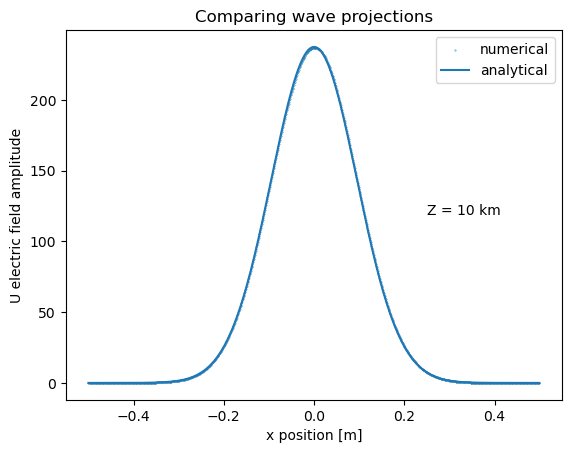

In [14]:
'Wave profiles 2D'

# bound = 0.1

# plt.plot(Xgrid[0], u_evol[0][:, Nx//2], label='initial')
# plt.plot(Xgrid[0], u_analytical[0][:, Nx//2], label='initial_analytical')

plt.scatter(Xgrid[0], u_evol[Nb_evol-1][:, Nx//2], label='numerical', s=.1)
plt.plot(Xgrid[0], u_analytical[Nb_evol - 1][:, Nx//2], label='analytical')
plt.text(L/4, np.max(u_evol[Nb_evol-1])/2, f"Z = {Z * 1E-3:.2g} km")
# plt.plot(Xgrid[0], u_analytical2[-1][:, Nx//2], label='analytical gauss')
# plt.plot(Xgrid[0], u_analytical3[-1][:, Nx//2], label='analytical new')

plt.ylabel('U electric field amplitude')
plt.xlabel('x position [m]')
# plt.xlim(-bound, bound)
plt.legend()
plt.title("Comparing wave projections")
# plt.show()
plt.savefig(f"screen/profile_{name}.png", dpi=300)

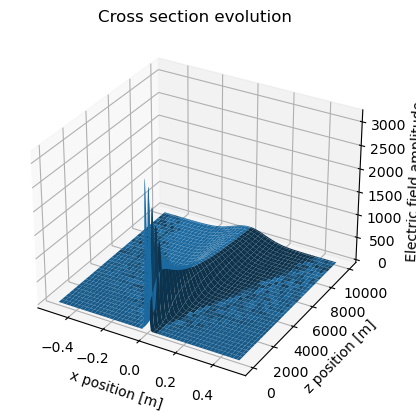

In [15]:
fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')
ax3d.set_title('Cross section evolution')

Xtemp, Zgrid = np.meshgrid(_range_spatial, Z_arr)
U = u_evol[:, :, Nx//2]

ax3d.plot_surface(Xtemp, Zgrid, U)

ax3d.set_xlabel("x position [m]")
ax3d.set_ylabel("z position [m]")
ax3d.set_zlabel("Electric field amplitude")
plt.savefig(f"screen/cross_section_evolution_{name}.png", dpi=300)

In [ ]:
plt.title('Error')

e = np.abs((u_evol - u_analytical))
err_evol = np.sum(e, axis=(1, 2)) / np.sum(u_analytical, axis=(1, 2))
plt.semilogy(Z_arr, err_evol)
plt.savefig(f"screen/err_{name}.png", dpi=300)

In [ ]:
'Surface plot of propagated wave'

bound = 0.1
fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')
ax3d.set_title("3D view of the final wave")
# ax3d.set_aspect('equal')
# ax3d.set_ylim3d(-bound, bound)
# ax3d.set_xlim3d(-bound, bound)


ax3d.plot_surface(Xgrid, Ygrid, u_evol[-1])

ax3d.set_xlabel("x position [m]")
ax3d.set_ylabel("y position [m]")
ax3d.set_zlabel("Electric field amplitude")

# ax3d.plot_surface(s.x, s.y, u_evol[0])
# plt.savefig(f"viz/3dplot_{name}.png", dpi=300)

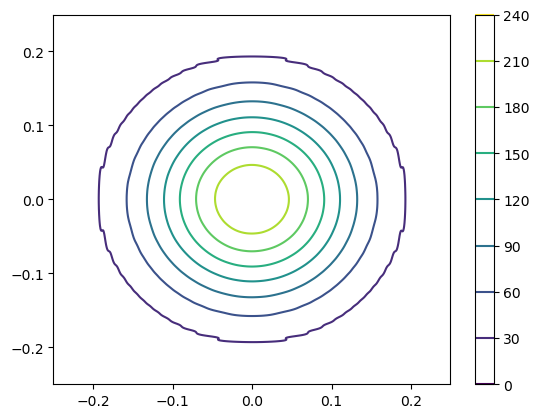

In [16]:
'Contour plot'

plt.contour(Xgrid, Ygrid, np.abs(u_evol[-1]))
plt.colorbar()
plt.savefig(f"screen/contour_plot{name}.png", dpi=300)

In [ ]:
'Animated profile'

fig , ax = plt.subplots()
ax = plt.axes()
m = np.max(u_evol)

line1, = ax.plot(Xgrid[0], u_evol[0, :, Nx//2], label='numerical')
line2, = ax.plot(Xgrid[0], u_analytical[0, :, Nx//2], label='analytical')
t = ax.text(L/4, m/2, "z = 0 km")
ax.set_title("Animated profile")
ax.legend()
#ax.set_yscale('log')

def animate(i):
    global t, line1, line2
    t.set_text(f"z = {i * Z * 1E-3 / Nb_evol:.2g} km")
    line1.set_data(Xgrid[0], u_evol[i, :, Nx//2])
    line2.set_data(Xgrid[0], u_analytical[i, :, Nx//2])


anim = FuncAnimation(fig, animate, frames=range(Nb_evol))
anim.save(f"screen/projection_anim_{name}.mp4", fps=Nb_evol//10)

In [ ]:
'Contour plot animation'

fig, ax = plt.subplots()
ax.set_title("Contour animation")

c = ax.contour(Xgrid, Ygrid, np.abs(u_evol[0]))
# plt.colorbar()

def animate(i):
    ax.clear()
    return plt.contour(Xgrid, Ygrid, np.abs(u_evol[i]))

anim = FuncAnimation(fig, animate, frames=range(Nb_evol))
anim.save(f"screen/contour_anim_{name}.mp4", fps=Nb_evol//10)

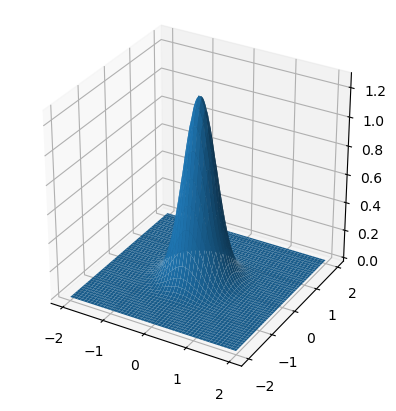

In [24]:
'Animated 3D surface plot'
bound = 0.01

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
graph = ax.plot_surface(Xgrid, Ygrid, u_evol[0])
m = np.max(u_evol)
# ax3d.set_aspect('equal')
ax.set_ylim3d(-bound, bound)
ax.set_xlim3d(-bound, bound)
ax.set_zlim3d(-m/4, m)

def update(u):
    ax.clear()
    ax.set_zlim3d(0, m)
    ax.plot_surface(Xgrid, Ygrid, u)

anim = FuncAnimation(fig, update, u_evol)
anim.save(f"screen/3d_anim_{name}.mp4")

In [16]:
'Computing radius and com'

power, x_c, y_c, radii = Diag3D(u_evol, Xgrid, Ygrid)
power_a, x_ca, y_ca, radii_a = Diag3D(u_analytical, Xgrid, Ygrid)
new_rad = np.zeros(Nb_evol)
for i in range(Nb_evol):
    Z_r = 0.5 * k * w_0 ** 2
    new_rad[i] = w_0 * np.sqrt(1+( i * Z/(Z_r*Nb_evol))**2) 
    


In [ ]:
plt.title("Radius")
plt.plot(Z_arr, radii, label='numerical')
plt.plot(Z_arr, radii_a, label='analytical')
plt.plot(Z_arr, new_rad/np.sqrt(2), label='analytical2')
plt.plot(Z_arr, L / 2 * np.ones_like(Z_arr), '--',  label='boundary')
plt.legend()
plt.savefig(f"screen/radius_{name}.png")

In [ ]:
plt.title("Power")
plt.plot(Z_arr, power, label='numerical')
# plt.plot(Z_arr, power_a, label='analytical')
plt.legend()
# plt.savefig(f"viz/power_{name}.png", dpi=300)

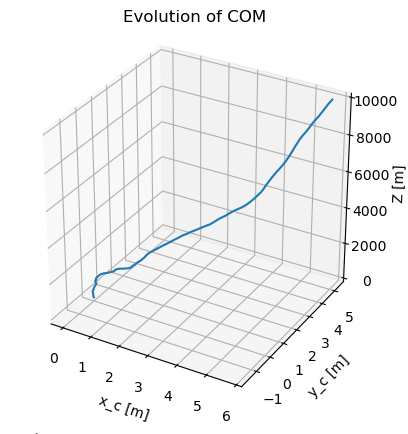

In [17]:
'Plotting evolution of COM'
# bound = 0.03
fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')
ax3d.set_title("Evolution of COM")
ax3d.set_aspect('equal')

ax3d.plot(x_c, y_c, np.linspace(0, Z, Nb_evol))
#ax3d = fig.add_subplot(projection='3d')
# ax3d.set_ylim3d(-bound, bound)
# ax3d.set_xlim3d(-bound, bound)
ax3d.set_xlabel("x_c [m]")
ax3d.set_ylabel("y_c [m]")
ax3d.set_zlabel("Z [m]")
ax3d.view_init(30, 300)
plt.savefig(f"screen/COM_3D_{name}.png")

# ax3d.plot_surface(s.x, s.y, u_evol[0])
# plt.savefig(f"viz/COMdeviation_{name}.png", dpi=300)

In [ ]:
'Plotting COM.x, COM.y'

plt.scatter(np.linspace(0, Z, Nb_evol), x_c, label='x_c')
plt.scatter(np.linspace(0, Z, Nb_evol), y_c, label='y_c')
np.max(np.abs(x_c-y_c))
plt.savefig(f"screen/COM_2D_{name}.png")